In [ ]:
!wget https://raw.githubusercontent.com/summitgao/CAMixer/main/preclassify.py

In [ ]:
import numpy as np
import skimage
from skimage import io, measure
import random
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from preclassify import del2, srad, dicomp, FCM, hcluster
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
from collections import  Counter


im1_path = 'Sulzberger2_1.bmp'
im2_path = 'Sulzberger2_2.bmp'
imgt_path = 'Sulzberger2_gt.bmp'


# important parameter
patch_size = 7

In [ ]:
def image_normalize(data):
    import math
    _mean = np.mean(data)
    _std = np.std(data)
    npixel = np.size(data) * 1.0
    min_stddev = 1.0 / math.sqrt(npixel)
    return (data - _mean) / max(_std, min_stddev)

def image_padding(data,r):
    if len(data.shape)==3:
        data_new=np.lib.pad(data,((r,r),(r,r),(0,0)),'constant',constant_values=0)
        return data_new
    if len(data.shape)==2:
        data_new=np.lib.pad(data,r,'constant',constant_values=0)
        return data_new
#生成自然数数组并打乱
def arr(length):
  arr=np.arange(length-1)
  #print(arr)
  random.shuffle(arr)
  #print(arr)
  return arr


# 在每个像素周围提取 patch ，然后创建成符合 pytorch 处理的格式
def createTrainingCubes(X, y, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    # 把类别 uncertainty 的像素忽略
    ele_num1 = np.sum(y==1)
    ele_num2 = np.sum(y==2)
    print(X.shape[2])
    patchesData_1 = np.zeros( (ele_num1, patch_size, patch_size, X.shape[2]) )
    patchesLabels_1 = np.zeros(ele_num1)

    patchesData_2 = np.zeros((ele_num2, patch_size, patch_size, X.shape[2]))
    patchesLabels_2 = np.zeros(ele_num2)

    patchIndex_1 = 0
    patchIndex_2 = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            # remove uncertainty pixels
            if y[r-margin, c-margin] == 1 :
                patch_1 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_1[patchIndex_1, :, :, :] = patch_1
                patchesLabels_1[patchIndex_1] = y[r-margin, c-margin]
                patchIndex_1 = patchIndex_1 + 1
            elif y[r-margin, c-margin] == 2 :
                patch_2 = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData_2[patchIndex_2, :, :, :] = patch_2
                patchesLabels_2[patchIndex_2] = y[r-margin, c-margin]
                patchIndex_2 = patchIndex_2 + 1
    patchesLabels_1 = patchesLabels_1-1
    patchesLabels_2 = patchesLabels_2-1
    
    #调用arr函数打乱数组
    arr_1=arr(len(patchesData_1))
    arr_2=arr(len(patchesData_2))

    train_len=8000  #设置训练集样本数
    pdata=np.zeros((train_len, patch_size, patch_size, X.shape[2]))
    plabels = np.zeros(train_len)
    
    for i in range(7000):
      pdata[i,:,:,:]=patchesData_1[arr_1[i],:,:,:]
      plabels[i]=patchesLabels_1[arr_1[i]]
    for j in range(7000,train_len):
      pdata[j,:,:,:]=patchesData_2[arr_2[j-7000],:,:,:]
      plabels[j]=patchesLabels_2[arr_2[j-7000]]

    return pdata, plabels


def createTestingCubes(X, patch_size):
    # 给 X 做 padding
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = image_padding(X, margin)
    patchesData = np.zeros( (X.shape[0]*X.shape[1], patch_size, patch_size, X.shape[2]) )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchIndex = patchIndex + 1
    return patchesData   


#  Inputs:  gtImg  = ground truth image
#           tstImg = change map
#  Outputs: FA  = False alarms
#           MA  = Missed alarms
#           OE  = Overall error
#           PCC = Overall accuracy
def evaluate(gtImg, tstImg):
    gtImg[np.where(gtImg>128)] = 255
    gtImg[np.where(gtImg<128)] = 0
    tstImg[np.where(tstImg>128)] = 255
    tstImg[np.where(tstImg<128)] = 0
    [ylen, xlen] = gtImg.shape
    FA = 0
    MA = 0
    label_0 = np.sum(gtImg==0)
    label_1 = np.sum(gtImg==255)
    print(label_0)
    print(label_1)

    for j in range(0,ylen):
        for i in range(0,xlen):
            if gtImg[j,i]==0 and tstImg[j,i]!=0 :
                FA = FA+1
            if gtImg[j,i]!=0 and tstImg[j,i]==0 :
                MA = MA+1
  
    OE = FA+MA
    PCC = 1-OE/(ylen*xlen)
    PRE=((label_1+FA-MA)*label_1+(label_0+MA-FA)*label_0)/((ylen*xlen)*(ylen*xlen))
    KC=(PCC-PRE)/(1-PRE)
    print(' Change detection results ==>')
    print(' ... ... FP:  ', FA)
    print(' ... ... FN:  ', MA)
    print(' ... ... OE:  ', OE)
    print(' ... ... PCC: ', format(PCC*100, '.2f'))
    print(' ... ... KC: ', format(KC*100, '.2f'))


def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    num = res.max()
    for i in range(1, num+1):
        idy, idx = np.where(res==i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

In [ ]:
# read image, and then tranform to float32
# 读取Sulzberger
im1 = io.imread(im1_path)[:,:,0].astype(np.float32)
im2 = io.imread(im2_path)[:,:,0].astype(np.float32)
from PIL import Image
im_gt = Image.open(imgt_path)
im_gt = np.array(im_gt)
np.unique(im_gt)
print(im1.shape)

im_di = dicomp(im1, im2)
ylen, xlen = im_di.shape
pix_vec = im_di.reshape([ylen*xlen, 1])


# hiearchical FCM clustering
# in the preclassification map, 
# pixels with high probability to be unchanged are labeled as 1
# pixels with high probability to be changed are labeled as 2
# pixels with uncertainty are labeled as 1.5
preclassify_lab = hcluster(pix_vec, im_di) # 350*290
print('... ... hiearchical clustering finished !!!')


mdata = np.zeros([im1.shape[0], im1.shape[1], 3], dtype=np.float32)
mdata[:,:,0] = im1
mdata[:,:,1] = im2
mdata[:,:,2] = im_di

mlabel = preclassify_lab

x_train, y_train = createTrainingCubes(mdata, mlabel, patch_size) #(10000,7,7,3)
x_train = x_train.transpose(0, 3, 1, 2)
print('... x train shape: ', x_train.shape)
print('... y train shape: ', y_train.shape)


x_test = createTestingCubes(mdata, patch_size)
x_test = x_test.transpose(0, 3, 1, 2)
print('... x test shape: ', x_test.shape)

(256, 256)
... ... 1st round clustering ... ...
... ... 2nd round clustering ... ...
... ... hiearchical clustering finished !!!
3
... x train shape:  (8000, 3, 7, 7)
... y train shape:  (8000,)
... x test shape:  (65536, 3, 7, 7)


In [ ]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_data = torch.FloatTensor(x_train)
        self.y_data = torch.LongTensor(y_train)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        
        #x=torch.FloatTensor(data_rotate(self.x_data[index].cpu().numpy()))
        #y=torch.FloatTensor(gasuss_noise(self.y_data[index]))
        #x=torch.FloatTensor(datarotate(self.x_data[index]))
        #return x,self.y_data[index]
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# 层注意力
class LayerAttention(nn.Module):
  def __init__(self, N):
      super(LayerAttention, self).__init__()
      self.N = N 
      self.weight = nn.Parameter(torch.eye(self.N,requires_grad=True))
      self.softmax  = nn.Softmax(dim=-1)
      
  def forward(self,x):
      # B x N x C x H x W
      B, N, C, H, W = x.size()
      group_mat = x.view(B, N, -1) # B*N*CHW 128*4*1568

      # 只更新权重矩阵对角线上的元素
      gradient_mask = torch.zeros(4, 4)
      gradient_mask[0, 0] = 1.0
      gradient_mask[1, 1] = 1.0
      gradient_mask[2, 2] = 1.0
      gradient_mask[3, 3] = 1.0
      device = torch.device('cuda:0')
      gradient_mask = gradient_mask.to(device) # 将tensor转移到cuda上,否则报错Expected all tensors to be on the same device（but cpu和cuda:0）
      self.weight.register_hook(lambda grad: grad.mul_(gradient_mask))
      
      weight = self.weight.unsqueeze(0).repeat([B,1,1])
      reweight = torch.bmm(weight, group_mat)
      # 进行转置
      reweight_trans = reweight.permute(0, 2, 1)

      weight_tmp = torch.bmm(reweight,reweight_trans)
      weight_tmp = torch.max(weight_tmp, -1, keepdim=True)[0].expand_as(weight_tmp)-weight_tmp # 让原矩阵的每一行最大值减去相应行的数
      attention_weight = self.softmax(weight_tmp)

      out = torch.bmm(attention_weight,reweight)
      out = out.view(B, N, C, H, W)

      out = out + x
      out = out.view(B, -1, H, W)

      return out

In [ ]:
# 噪声鲁棒的损失函数
class Loss(torch.nn.Module):
  def __init__(self, alpha=0.1, beta=0.9, classes=2):
      super(Loss, self).__init__()
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
      self.alpha = alpha
      self.beta = beta
      self.classes = classes
      self.ce = torch.nn.CrossEntropyLoss()

  def forward(self, pred, labels):
      # CE
      ce = self.ce(pred, labels)
      # MAE
      pred = F.softmax(pred, dim=1)
      label_one_hot = torch.nn.functional.one_hot(labels, self.classes).float().to(self.device)
      mae = 2 - 2 * (torch.sum(pred * label_one_hot, dim=1)) # 点乘的作用就是取pred的对应类别的那个预测概率
      # Loss
      loss = self.alpha * ce + self.beta * mae.mean()
      return loss

In [ ]:
class LANTNet(nn.Module):
    def __init__(self):
        super(LANTNet, self).__init__() 
        
        inchannel = 3
        self.conv1 = nn.Conv2d(inchannel, 8, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv1_1 = nn.Conv2d(8, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1_1 = nn.BatchNorm2d(32)


        self.conv2_1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_1 = nn.BatchNorm2d(16)
        self.conv2_11 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2_11 = nn.BatchNorm2d(32)


        self.conv2_2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.conv2_22 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2_22 = nn.BatchNorm2d(32)

        self.conv2_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2_3 = nn.BatchNorm2d(32)
        self.conv2_33 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2_33 = nn.BatchNorm2d(32)


        self.lam= LayerAttention(4)

        self.conv3 = nn.Conv2d(128, 4, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(4)

        self.linear1=nn.Linear(196, 10) 
        self.linear2=nn.Linear(10, 2)

    def forward(self, x):

        ori_out1 = F.relu(self.bn1(self.conv1(x)))
        m1 = F.relu(self.bn1_1(self.conv1_1(ori_out1)))# 统一到32个通道上来

        ori_out2 = F.relu(self.bn2_1(self.conv2_1(ori_out1)))
        m2 = F.relu(self.bn2_11(self.conv2_11(ori_out2)))# 统一到32个通道上来

        ori_out3 = F.relu(self.bn2_2(self.conv2_2(ori_out2)))
        m3 = F.relu(self.bn2_22(self.conv2_22(ori_out3)))# 统一到32个通道上来

        ori_out4 = F.relu(self.bn2_3(self.conv2_3(ori_out3)))
        m4 = F.relu(self.bn2_33(self.conv2_33(ori_out4)))# 统一到32个通道上来

        out5 = torch.stack([m1, m2, m3, m4],dim = 1)
        out5=self.lam(out5)
        out = F.relu(self.bn3(self.conv3(out5)))
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out_1 = self.linear1(out)
        out = self.linear2(out_1)

        return out

In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
istrain = True
# 网络放到GPU上
net =LANTNet().to(device)
criterion = Loss(alpha=0.1, beta=0.9, classes=2).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()

# 开始训练
total_loss = 0
for epoch in range(60):
    
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]  [loss avg: %.4f]  [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
print('Finished Training')

[Epoch: 1]  [loss avg: 10.6556]  [current loss: 0.0136]
[Epoch: 2]  [loss avg: 5.9442]  [current loss: 0.0072]
[Epoch: 3]  [loss avg: 4.2065]  [current loss: 0.0037]
[Epoch: 4]  [loss avg: 3.3369]  [current loss: 0.0011]
[Epoch: 5]  [loss avg: 2.7831]  [current loss: 0.0019]
[Epoch: 6]  [loss avg: 2.4313]  [current loss: 0.1196]
[Epoch: 7]  [loss avg: 2.1135]  [current loss: 0.0001]
[Epoch: 8]  [loss avg: 1.8628]  [current loss: 0.0000]
[Epoch: 9]  [loss avg: 1.6826]  [current loss: 0.0002]
[Epoch: 10]  [loss avg: 1.5552]  [current loss: 0.0015]
[Epoch: 11]  [loss avg: 1.4652]  [current loss: 0.0001]
[Epoch: 12]  [loss avg: 1.3754]  [current loss: 0.0005]
[Epoch: 13]  [loss avg: 1.2744]  [current loss: 0.0003]
[Epoch: 14]  [loss avg: 1.1987]  [current loss: 0.0000]
[Epoch: 15]  [loss avg: 1.1267]  [current loss: 0.0001]
[Epoch: 16]  [loss avg: 1.0637]  [current loss: 0.0000]
[Epoch: 17]  [loss avg: 1.0071]  [current loss: 0.0259]
[Epoch: 18]  [loss avg: 0.9652]  [current loss: 0.0000]


... ... row 50  handling ... ...
... ... row 100  handling ... ...
... ... row 150  handling ... ...
... ... row 200  handling ... ...
... ... row 250  handling ... ...
49184
16352
 Change detection results ==>
 ... ... FP:   990
 ... ... FN:   921
 ... ... OE:   1911
 ... ... PCC:  97.08
 ... ... KC:  92.22


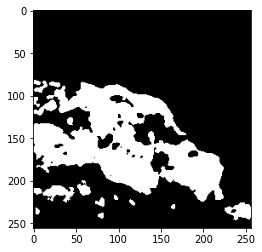

In [ ]:
# 逐像素预测类别
istrain=False
net.eval()
outputs = np.zeros((ylen, xlen))
glo_fin=torch.Tensor([]).cuda()
dct_fin=torch.Tensor([]).cuda()
for i in range(ylen):
    for j in range(xlen):
        img_patch = x_test[i*xlen+j, :, :, :]
        img_patch = img_patch.reshape(1, img_patch.shape[0], img_patch.shape[1], img_patch.shape[2])
        img_patch = torch.FloatTensor(img_patch).to(device)
        prediction = net(img_patch)

        prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
        outputs[i, j] = prediction + 1

            
    if (i+1) % 50 == 0:
        print('... ... row', i+1, ' handling ... ...')

outputs = outputs-1

plt.imshow(outputs, 'gray')
res = outputs*255
res = postprocess(res)
evaluate(im_gt, res)
plt.imshow(res, 'gray')
